As a talent sourcing and management company, we are interested in finding talented individuals for sourcing these candidates to technology companies. Finding talented candidates is not easy, for several reasons. The first reason is one needs to understand what the role is very well to fill in that spot, this requires understanding the client’s needs and what they are looking for in a potential candidate. The second reason is one needs to understand what makes a candidate shine for the role we are in search for. Third, where to find talented individuals is another challenge.

The nature of our job requires a lot of human labor and is full of manual operations. Towards automating this process we want to build a better approach that could save us time and finally help us spot potential candidates that could fit the roles we are in search for. Moreover, going beyond that for a specific role we want to fill in we are interested in developing a machine learning powered pipeline that could spot talented individuals, and rank them based on their fitness.

We are right now semi-automatically sourcing a few candidates, therefore the sourcing part is not a concern at this time but we expect to first determine best matching candidates based on how fit these candidates are for a given role. We generally make these searches based on some keywords such as “full-stack software engineer”, “engineering manager” or “aspiring human resources” based on the role we are trying to fill in. These keywords might change, and you can expect that specific keywords will be provided to you.

Assuming that we were able to list and rank fitting candidates, we then employ a review procedure, as each candidate needs to be reviewed and then determined how good a fit they are through manual inspection. This procedure is done manually and at the end of this manual review, we might choose not the first fitting candidate in the list but maybe the 7th candidate in the list. If that happens, we are interested in being able to re-rank the previous list based on this information. This supervisory signal is going to be supplied by starring the 7th candidate in the list. Starring one candidate actually sets this candidate as an ideal candidate for the given role. Then, we expect the list to be re-ranked each time a candidate is starred.

Data Description:

The data comes from our sourcing efforts. We removed any field that could directly reveal personal details and gave a unique identifier for each candidate.

Attributes:
id : unique identifier for candidate (numeric)

job_title : job title for candidate (text)

location : geographical location for candidate (text)

connections: number of connections candidate has, 500+ means over 500 (text)

Output (desired target):
fit - how fit the candidate is for the role? (numeric, probability between 0-1)

Keywords: “Aspiring human resources” or “seeking human resources”

Goal(s):

Predict how fit the candidate is based on their available information (variable fit)

Success Metric(s):

Rank candidates based on a fitness score.

Re-rank candidates when a candidate is starred.

Current Challenges:

We are interested in a robust algorithm, tell us how your solution works and show us how your ranking gets better with each starring action.

How can we filter out candidates which in the first place should not be in this list?

Can we determine a cut-off point that would work for other roles without losing high potential candidates?

Do you have any ideas that we should explore so that we can even automate this procedure to prevent human bias?

In [ ]:
import time
start_run = time.time()

In [138]:
!pip install --upgrade numpy gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 3.7 MB/s eta 0:00:00


In [139]:
!pip install -U transformers datasets bitsandbytes peft faiss-cpu sentence-transformers accelerate hf_xet trl

**RESTART SESSION FROM THE BEGINNING AND RUN ALL**

In [ ]:
# Imports
import numpy as np
import pandas as pd
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
import matplotlib.ticker as ticker
import random
from sklearn.model_selection import train_test_split
import re
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import metrics

#for models
from sklearn.metrics.pairwise import cosine_similarity #cosine similarity score
from sklearn.metrics import pairwise_distances
from sklearn.feature_extraction.text import TfidfVectorizer

#NATURAL LANGUAGE TOOLKIT
import nltk #Natural Language Toolkit(for NLP)
from nltk.corpus import stopwords #provides list of stop words to be filtered
from nltk.tokenize import word_tokenize #Tokenize the words (split the texts into individual words)
from nltk.util import ngrams #Generates ngrams (sequence of n consecutive words) from a text
from collections import Counter #A counter is a container that stores elements as dictionary keys, and their counts are stored as dictionary values.

import warnings
warnings.filterwarnings("ignore")
import transformers
transformers.logging.set_verbosity_error()

import gensim.downloader as api
from sentence_transformers import SentenceTransformer, util
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import random

import warnings
warnings.filterwarnings("ignore")

from datasets import Dataset
from sklearn.metrics.pairwise import cosine_similarity
import faiss
from transformers import (
    AutoTokenizer, AutoModelForCausalLM,
    TrainingArguments, Trainer, DataCollatorForLanguageModeling, pipeline
)
from peft import get_peft_model, LoraConfig, TaskType

In [ ]:
# Load data from csv file
data = pd.read_csv('potential-talents - Aspiring human resources - seeking human resources.csv')
df = pd.DataFrame(data)

In [ ]:
df.head()

,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN


CHECKING FOR MISSING VALUES IN DATA

In [ ]:
df.isnull().sum()

,0
id,0
job_title,0
location,0
connection,0
fit,104


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          104 non-null    int64  
 1   job_title   104 non-null    object 
 2   location    104 non-null    object 
 3   connection  104 non-null    object 
 4   fit         0 non-null      float64
dtypes: float64(1), int64(1), object(3)
memory usage: 4.2+ KB
None
               id  fit
count  104.000000  0.0
mean    52.500000  NaN
std     30.166206  NaN
min      1.000000  NaN
25%     26.750000  NaN
50%     52.500000  NaN
75%     78.250000  NaN
max    104.000000  NaN
id              0
job_title       0
location        0
connection      0
fit           104
dtype: int64

Value counts for location:
location
Kanada                                 12
Raleigh-Durham, North Carolina Area     8
Houston, Texas Area                     8
Greater New York City Area              7
Houston, Texas             

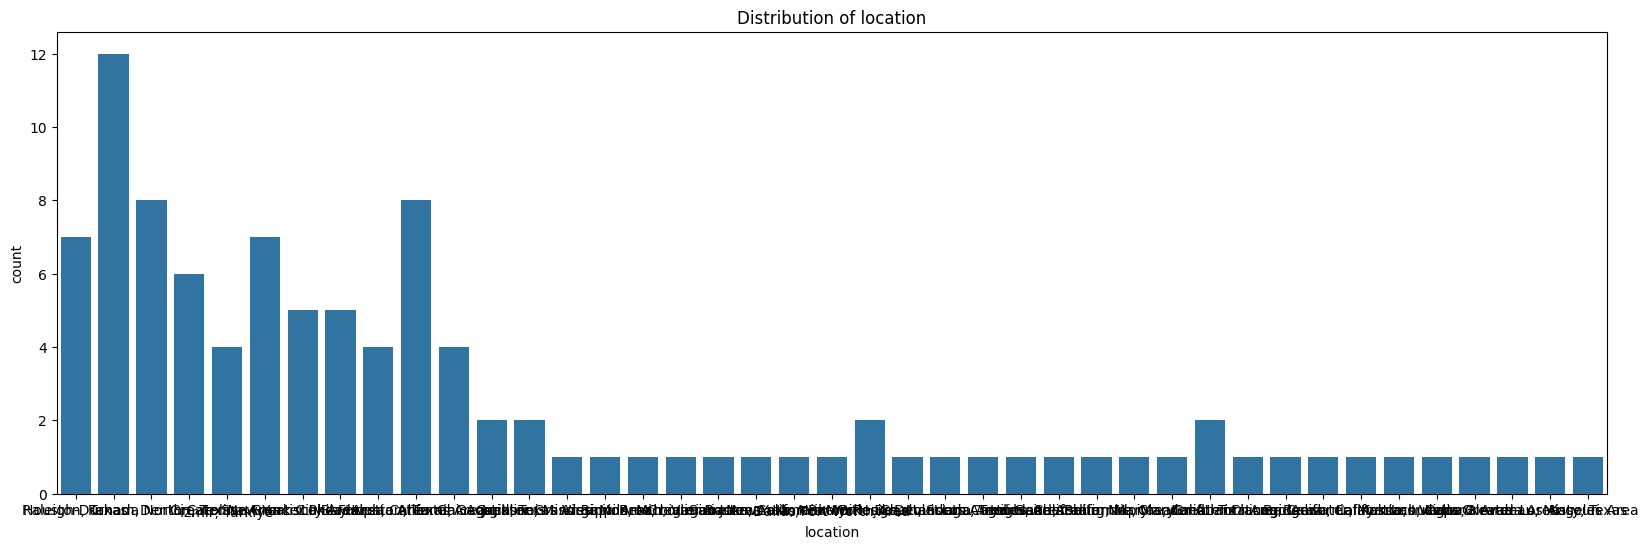


Value counts for connection:
connection
500+     44
85        7
61        7
44        6
1         5
2         4
4         2
7         2
57        2
390       2
103       1
48        1
18        1
71        1
19        1
415       1
9         1
64        1
39        1
155       1
349       1
174       1
40        1
50        1
268       1
455       1
52        1
409       1
212       1
16        1
5         1
82        1
49        1
Name: count, dtype: int64


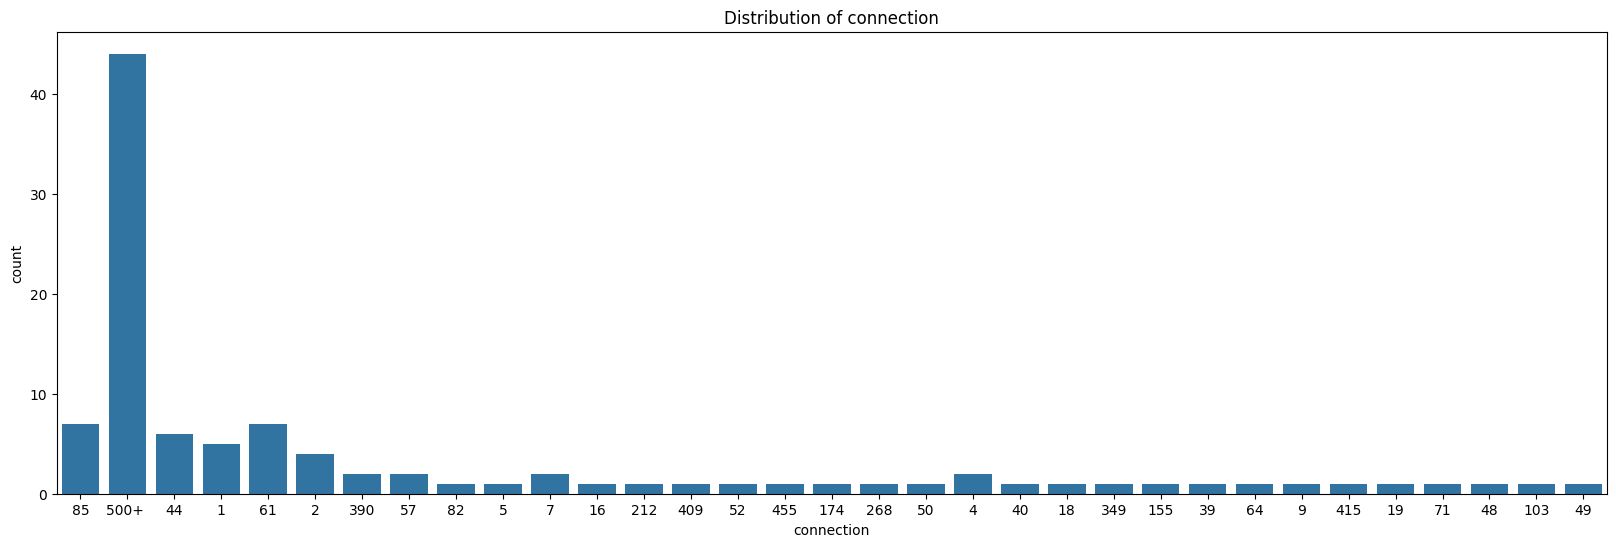


Top 10 job titles:
job_title
2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional       7
Aspiring Human Resources Professional                                                                          7
Student at Humber College and Aspiring Human Resources Generalist                                              7
People Development Coordinator at Ryan                                                                         6
Native English Teacher at EPIK (English Program in Korea)                                                      5
Aspiring Human Resources Specialist                                                                            5
HR Senior Specialist                                                                                           5
Student at Chapman University                                                                                  4
SVP, CHRO, Marketing & Communications, CSR Officer | ENGIE | Houst

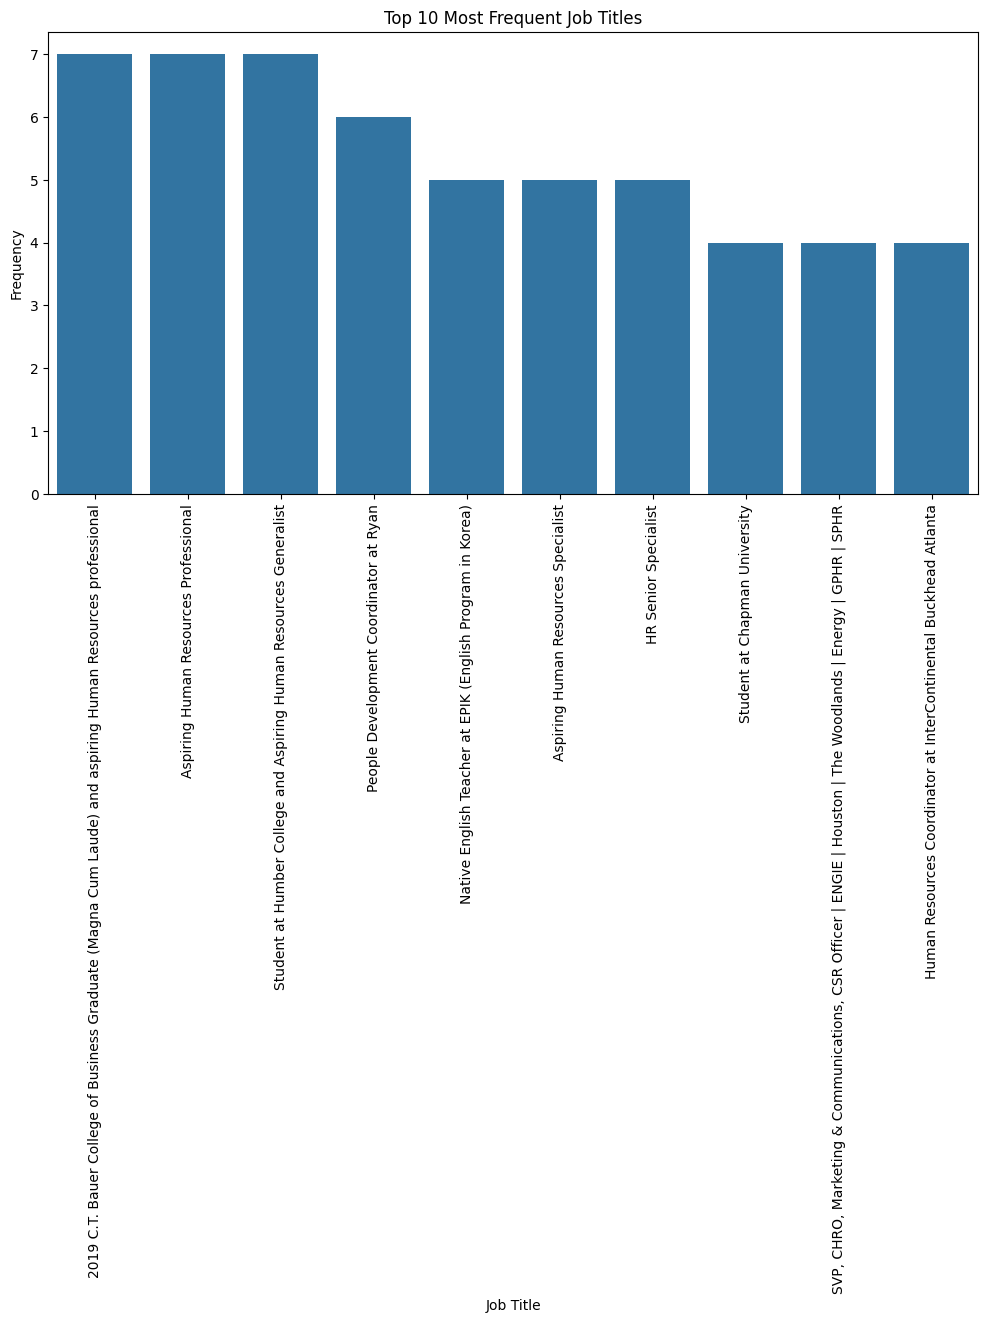

In [ ]:
# prompt: Using dataframe df: explorative data analysis
# Display basic info
print(df.info())

# Summary statistics for numerical columns
print(df.describe())

# Check for missing values
print(df.isnull().sum())

# Explore categorical features
for col in ['location', 'connection']:
    print(f"\nValue counts for {col}:")
    print(df[col].value_counts())
    plt.figure(figsize=(20, 6))
    sns.countplot(x=col, data=df)
    plt.title(f'Distribution of {col}')
    plt.show()


# Explore job titles (top 10 most frequent)
top_job_titles = df['job_title'].value_counts().head(10)
print("\nTop 10 job titles:")
print(top_job_titles)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_job_titles.index, y=top_job_titles.values)
plt.xticks(rotation=90)
plt.title("Top 10 Most Frequent Job Titles")
plt.xlabel("Job Title")
plt.ylabel("Frequency")
plt.show()

In [ ]:
#The function below creates a dataframe with count and frequencies for a given column.
def value_counts_percentage(dataset, column):
    ''' value.counts() method extended by displaying percentage '''

    a = dataset[column].value_counts()
    b = dataset[column].value_counts(normalize=True) * 100

    return pd.concat([a,b.round(2)], axis=1, keys=['N', '%'])

In [ ]:
def plot_density(dataset, col, ax, plot_gaussian = True, color="Blue"):
    '''
    Extension of the seaborn histogram that plots, for a given column,
    an estimated normal distribution (if requested) on top of the fitted data distribution.
    '''
    ncount = len(dataset)

    if plot_gaussian:
        std = dataset[col].std()
        mean = dataset[col].mean()

    #plot histogram using seaborn
    ax = sns.histplot(dataset[col], ax=ax, color=color, kde=True, stat="probability", kde_kws={"bw_adjust":3})

    if plot_gaussian:
        # Limiting our gaussian to the limits from the above plot
        xmin, xmax = ax.get_xlim()
        xnorm = np.arange(xmin, xmax, 0.001)
        ynorm = norm.pdf(xnorm, mean, std)
        ax.plot(xnorm, ynorm, 'r', lw=2)
        ax.legend(["data distribution", "estimated normal distribution"], loc="upper center",
                  bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)

    ax.set_title(col)
    ax.set_xlabel("")


def plot_pie(dataset, col, ax):
    '''
    Pandas' pie plot wrapper
    '''
    ax = dataset[col].value_counts().plot(kind='pie', ax=ax)
    ax.set_title(col)
    ax.set_ylabel("")

def plot_count(dataset, col, ax, order = None, show_percent=True, rotate_label = True, add_args={"palette": "Set2"}):
    '''
    Extending the seaorn countplot to get frequencies and counts in a pretty way.
    '''

    ncount = len(dataset)

    if order is None:
        order = np.sort(dataset[col].unique())

    # plot seaborn countplot
    ax = sns.countplot(data=dataset, x=col, ax=ax, order=order, **add_args)

    # Get y limit (number of elements)
    _ ,max_nb = ax.get_ylim()
    # Transform this limit into a frequency in [0, 100]
    freq_lim = (max_nb * 100/ ncount)

    # Duplicate the ax
    ax2 = ax.twinx()

    #Move duplicate y axis ticks to the left
    ax2.yaxis.tick_left()

    #Move original y axis ticks to the right
    ax.yaxis.tick_right()

    # Swap the label positions to match the ticks
    ax.yaxis.set_label_position('right')
    ax2.yaxis.set_label_position('left')
    ax2.set_ylabel('Frequency [%]')

    # We want to write the frequency on top of each bar
    if show_percent:
        # for every bar
        for p in ax.patches:
            x=p.get_bbox().get_points()[:,0]
            y=p.get_bbox().get_points()[1,1]
            if not math.isnan(x.mean()) and not math.isnan(y):
                # Write frequency at an x and y coordinate
                ax.text(x.mean(), y, '{:.1f}%'.format(100.*y/ncount),
                    ha='center', va='bottom')

    # Set y axis limit for counts and frequencies
    ax2.set_ylim(0,freq_lim)
    ax.set_ylim(0,max_nb)

    # set ticks for count
    ax.yaxis.set_major_locator(ticker.LinearLocator(11))
    ax.yaxis.set_tick_params(which="major")

    # set ticks for frequencies
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(freq_lim/10))
    ax2.yaxis.set_tick_params(which="major")

    # remove grid for ax 2 (keep only ax)
    ax2.grid(False)
    ax.grid(False)
    ax.set_xlabel("")
    if rotate_label:
        # rotate tick labels on the x axis / / /
        _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    ax.set_title(col)

def plot(kind, dataset, columns=None, fig_title="Count/Frequency plots", fontsizes = 10, **kwargs):
    '''
    Wrapper function that takes care of plot wise sizes and calling the wanted procedure
    '''

    # plot choices
    kind_dict = {
        'pie': plot_pie,
        'count': plot_count,
        'density': plot_density}

    if kind not in kind_dict:
        raise ValueError(f"{kind} is not a valid kind, has to be one of {kind_dict.keys()}")

    if columns is None:
        # us all dataset columns
        columns = list(dataset.columns)

    fig = None

    # Setting font sizes
    plt.rc('xtick', labelsize=fontsizes*1.5)
    plt.rc('ytick', labelsize=fontsizes*1.5)
    plt.rc('axes', labelsize=fontsizes*2)
    plt.rc('legend', fontsize=fontsizes*1.5, title_fontsize=0)
    plt.rc('axes', titlesize=2*fontsizes)
    plt.rc('font', size=1.7*fontsizes)

    # Scale of the figure in ax (to be used later)
    figsize_scale = fontsizes

    if not isinstance(columns, list):
        # columns has to be a list
        if isinstance(columns, str):
            columns = [columns]
        else:
            columns = list(columns)

    if len(columns) == 1: # Only variable to plot
        ncols, nrows = 1, 1
        figsize_scale *= 1.5 # double figsize
    else:
        ncols, nrows = 2, math.ceil(len(columns) / 2)

    fig, axes = plt.subplots(figsize=(figsize_scale*2*ncols, figsize_scale*0.75*nrows), nrows=nrows, ncols=ncols)

    if ncols == 1 and nrows == 1:
        # We need a list of axes
        axes = np.array([axes])

    # Plot
    do_plots(dataset, columns, axes, kind_dict[kind], **kwargs)

    fig.suptitle(fig_title + "\n\n", fontsize=fontsizes*2.5)
    plt.tight_layout()
    #Reset plot setting to original
    sns.reset_orig()

def do_plots(dataset, columns, axes, plot_func, **kwargs):
    '''
    Calls the plotting function on every axis and removes unused axes.
    '''
    axes = axes.flat

    #plot every variable
    for index, col in enumerate(columns):
        plot_func(dataset, col, axes[index], **kwargs)

    # remove empty axes
    for empty in range(len(columns), len(axes)):
        axes[empty].axis("off")

In [ ]:
print(value_counts_percentage(df, 'job_title'))

                                                    N     %
job_title                                                  
2019 C.T. Bauer College of Business Graduate (M...  7  6.73
Aspiring Human Resources Professional               7  6.73
Student at Humber College and Aspiring Human Re...  7  6.73
People Development Coordinator at Ryan              6  5.77
Native English Teacher at EPIK (English Program...  5  4.81
Aspiring Human Resources Specialist                 5  4.81
HR Senior Specialist                                5  4.81
Student at Chapman University                       4  3.85
SVP, CHRO, Marketing & Communications, CSR Offi...  4  3.85
Human Resources Coordinator at InterContinental...  4  3.85
Seeking Human Resources HRIS and Generalist Pos...  4  3.85
Advisory Board Member at Celal Bayar University     4  3.85
Aspiring Human Resources Management student see...  2  1.92
Seeking Human Resources Opportunities               2  1.92
Seeking Human  Resources Opportunities. 

**A. EMBEDDING MODELS**

**1. TF - IDF VECTORIZER**

TF-IDF (Term Frequency–Inverse Document Frequency) is a foundational NLP technique used in this project to evaluate how important a word is to a document (candidate profile) relative to a collection (all candidate profiles).

In [ ]:
#Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

#Fit the vectorizer on the 'job_title' column and transform the text into a TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(df['job_title'])

#View the result (sparse matrix of TF-IDF features)
print(tfidf_matrix)

  (0, 0)	0.33906045785453615
  (0, 18)	0.33906045785453615
  (0, 33)	0.2794338755661507
  (0, 27)	0.3006001244319959
  (0, 67)	0.33906045785453615
  (0, 104)	0.33906045785453615
  (0, 41)	0.33906045785453615
  (0, 93)	0.33906045785453615
  (0, 14)	0.19639141675448127
  (0, 77)	0.14482685321655558
  (0, 142)	0.14482685321655558
  (0, 133)	0.2475178508599569
  (1, 113)	0.33333333333333337
  (1, 54)	0.6666666666666667
  (1, 167)	0.33333333333333337
  (1, 58)	0.33333333333333337
  (1, 135)	0.33333333333333337
  (1, 91)	0.33333333333333337
  (2, 14)	0.5215649714328273
  (2, 77)	0.38462278448263953
  (2, 142)	0.38462278448263953
  (2, 133)	0.6573435995641216
  (3, 127)	0.5149529932022894
  (3, 45)	0.5149529932022894
  (3, 38)	0.4521838612511605
  :	:
  (99, 77)	0.21077883443133472
  (99, 142)	0.21077883443133472
  (99, 150)	0.19888715779446964
  (99, 107)	0.246731757685405
  (99, 130)	0.29457635757634043
  (99, 68)	0.34242095746727585
  (99, 1)	0.34242095746727585
  (99, 55)	0.34242095746727

Vocabulary learning: extract unique tokens from 'df['job_title']' and compute their TF-IDF scores

In [ ]:
tfidf_vectorizer.get_feature_names_out() #Get the list of unique tokens (features) learned by the vectorizer

array(['2019', '2020', '2621', '408', '709', 'administration',
       'administrative', 'admissions', 'advisory', 'america', 'analyst',
       'analytics', 'army', 'arts', 'aspiring', 'assistant', 'atlanta',
       'bachelor', 'bauer', 'bayar', 'beach', 'benefits', 'beneteau',
       'biology', 'board', 'brand', 'buckhead', 'business', 'care',
       'celal', 'center', 'chapman', 'chro', 'college', 'communications',
       'community', 'compensation', 'conflict', 'coordinator', 'create',
       'csr', 'cum', 'customer', 'data', 'delphi', 'development',
       'director', 'employment', 'endemol', 'energetic', 'energy',
       'engaging', 'engie', 'engineer', 'english', 'entry', 'environment',
       'environmental', 'epik', 'excellence', 'executive', 'experienced',
       'ey', 'focused', 'generalist', 'gis', 'gphr', 'graduate',
       'graduating', 'groupe', 'guard', 'hardware', 'heil', 'helping',
       'houston', 'hr', 'hris', 'human', 'humber', 'illinois',
       'inclusive', 'india

**INPUT SEARCH VALUE**

In [ ]:
search= input ("Please enter the job search: ")

**TRANSFORM AND VECTORIZE THE INPUT**

In [ ]:
#Transform the search input as a new row
new_row=pd.DataFrame({'id':[0],'job_title':[search], 'location':['NA'], 'fit':[0]})

# Transform the new job title using the previously fitted TF-IDF vectorizer
new_tfidf_vector = tfidf_vectorizer.transform(new_row['job_title'])

**PRINTING THE SHAPE TO CHECK COMPACTIBILITY IN MATRIX MULTIPLICATION**

In [ ]:
print(tfidf_matrix.shape)
print(new_tfidf_vector.shape)

(104, 181)
(1, 181)


**Cosine Similarity** -
Cosine similarity is used to measure the similarity between the new job title and the existing job titles in the dataset

In [ ]:
cosine_sim= cosine_similarity(new_tfidf_vector,tfidf_matrix)#measures how similar the new job title is to each existing one (range: 0 to 1).
print(cosine_sim)

[[0.28375909 0.         0.753591   0.         0.         0.69567872
  0.4361722  0.         0.4361722  0.21138856 0.         0.
  0.19430422 0.28375909 0.28375909 0.         0.753591   0.
  0.28375909 0.         0.753591   0.         0.         0.69567872
  0.4361722  0.         0.39564317 0.2878165  0.39564317 0.2878165
  0.28375909 0.         0.753591   0.         0.         0.69567872
  0.4361722  0.         0.4361722  0.21138856 0.         0.
  0.19430422 0.28375909 0.         0.753591   0.         0.
  0.69567872 0.4361722  0.         0.4361722  0.21138856 0.
  0.         0.19430422 0.28375909 0.753591   0.         0.69567872
  0.         0.21138856 0.         0.         0.19430422 0.34799962
  0.20673821 0.25016373 0.14622958 0.11259174 0.25299409 0.37472449
  0.57679398 0.46015863 0.10859318 0.21816311 0.10824288 0.25299409
  0.29767933 0.         0.15410443 0.2847913  0.         0.15134215
  0.         0.         0.         0.25753129 0.22617284 0.
  0.         0.         0.   

In [ ]:
cosine_sim.shape

(1, 104)

In [ ]:
#Create a lookup mapping from job titles to their row indices in the DataFrame
#Retrieving rows by job title.
#Mapping similarity results back to the original dataset.
indices=pd.Series(df.index, index=df['job_title']).drop_duplicates()

**DEFINE FUNCTIONS TO RUN PROJECT**

In [ ]:
def get_sim_recommendations(title, cosine_sim, indices):
  sim_scores = sorted(enumerate(cosine_sim), key=lambda x: x[1], reverse=True)  # Sort the job titles based on the similarity scores
  #in ascending order, indices keep track of the the original position

  sim_scores = sim_scores[0:11]  # Get the scores of the 10 most similar job titles
  job_indices = [i[0] for i in sim_scores]  # Get the indices of the most similar job titles
  similarity_scores = [i[1] for i in sim_scores]  # Get the similarity scores of the most similar job titles

  #Retrieve the matching jobs from the original DataFrame
  similar_jobs= df[['job_title', 'location', 'connection']].iloc[job_indices]  # Get the names of the most similar job titles
  similar_jobs['similarity_score'] = similarity_scores  # Add the similarity scores as a new column
  return similar_jobs

**PRINT RESULT**

In [ ]:
print(f"Search: {search}") #Display the user's search query for context
pd.DataFrame(get_sim_recommendations(search, cosine_sim.T, indices)) #Include cosine scores and other features

Search: Aspiring human resources


,job_title,location,connection,similarity_score
2,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,[0.7535909978974563]
16,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,[0.7535909978974563]
20,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,[0.7535909978974563]
32,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,[0.7535909978974563]
45,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,[0.7535909978974563]
57,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,[0.7535909978974563]
96,Aspiring Human Resources Professional,"Kokomo, Indiana Area",71,[0.7535909978974563]
5,Aspiring Human Resources Specialist,Greater New York City Area,1,[0.6956787236144734]
23,Aspiring Human Resources Specialist,Greater New York City Area,1,[0.6956787236144734]
35,Aspiring Human Resources Specialist,Greater New York City Area,1,[0.6956787236144734]


**2. WORD2VEC**

Word2Vec is a neural embedding technique that transforms words into dense vector representations, capturing semantic meaning based on context.

**FIRSTLY TRAIN WORD2VEC MODEL**

In [ ]:
# Tokenize job titles into individual words (basic whitespace split)
#.astype(str): Ensures all entries are strings, which avoids errors if NaN or non-string types are present.
#.lower(): Converts all text to lowercase for consistency (optional but usually useful in NLP).
#.split(): Splits strings by whitespace into lists of tokens.
df['job_title_tokens'] = df['job_title'].astype(str).apply(lambda x: x.lower().split())

**INSTALL NECESSARY LIBRARIES**

In [ ]:
#Import the libraries
from gensim.models import FastText, Word2Vec, keyedvectors

In [ ]:
#Tokenizing the job titles by splitting them into individual words
df['job_title_tokens'] = df['job_title'].apply(lambda x: x.split()) #Break job titles into word tokens

In [ ]:
#Training a Word2Vec model using the tokenized job titles
model= Word2Vec(
    sentences=df['job_title_tokens'], #Provide tokenizes job titles as input sentences
    vector_size=100, #Set the dimensionality of the word vectors
    window=5, #Specify the window size for context words
    min_count=1, #Include words that appear at least once
    workers=4 #Use 4 threads for parallel processing
    )

In [ ]:
def get_average_embedding(job_title_tokens):
    """
    Computes the average Word2Vec embedding for a list of job title tokens,
    first attempting to use model.wv, then falling back to model itself.

    Parameters:
        job_title_tokens (list): A list of strings (words from a job title).
        model: A Word2Vec or KeyedVectors model.

    Returns:
        np.ndarray or None: The average embedding vector or None if no valid tokens are found.
    """
    try:
        embeddings = [model.wv[word] for word in job_title_tokens if word in model.wv]
    except AttributeError:
        embeddings = [model[word] for word in job_title_tokens if word in model]

    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return None

In [ ]:
# Apply the get_average_embedding function to each list of tokens
df['job_title_embedding'] = df['job_title_tokens'].apply(get_average_embedding)

df[['job_title', 'job_title_embedding']].head() #Display the first 5 rows

,job_title,job_title_embedding
0,2019 C.T. Bauer College of Business Graduate (...,"[-0.0020150642, 0.0029246542, 0.0018518363, 0...."
1,Native English Teacher at EPIK (English Progra...,"[-0.0005830062, 0.00074866635, -0.004661155, -..."
2,Aspiring Human Resources Professional,"[-0.0027600015, 0.0015833578, 0.0044471454, -0..."
3,People Development Coordinator at Ryan,"[0.000708149, -0.004404255, -0.0020352402, 2.0..."
4,Advisory Board Member at Celal Bayar University,"[-0.0027589723, -0.0002783602, -0.0018380292, ..."


In [ ]:
def get_search_embedding(search_text, model):
    """
    Converts a search query into an average Word2Vec embedding.

    Parameters:
    - search_text (str): The search input (job title)
    - model (gensim.models.Word2Vec): A trained Word2Vec model

    Returns:
    - numpy.ndarray or None: The average vector representation of the search tokens
    """
    search_tokens = search_text.split()  # Tokenize and normalize to lowercase

    try:
        search_embeddings = [model.wv[word] for word in search_tokens if word in model.wv]
    except AttributeError:
        search_embeddings = [model[word] for word in search_tokens if word in model]

    if search_embeddings:
        return np.mean(search_embeddings, axis=0)
    else:
        return None

def get_recommendations(search_text, model, job_title_embeddings, job_titles, n=100):
    """
    Get top N job title recommendations based on semantic similarity.

    Parameters:
    - search_text (str): The job title input to search for
    - model (Word2Vec): Trained Word2Vec model
    - job_title_embeddings (List[np.array]): Precomputed average embeddings for job titles
    - job_titles (List[str]): Original job titles
    - n (int): Number of top recommendations to return

    Returns:
    - pd.DataFrame: Recommended jobs with metadata and similarity scores
    """
    search_embedding = get_search_embedding(search_text, model)

    if search_embedding is None:
        return pd.DataFrame({"Error": ["Search query contains unknown words"]})

    search_embedding = search_embedding / np.linalg.norm(search_embedding)

    valid_indices = [i for i, vec in enumerate(job_title_embeddings) if vec is not None]
    valid_embeddings = [job_title_embeddings[i] for i in valid_indices]
    similarities = cosine_similarity([search_embedding], valid_embeddings)[0]
    #Rank and extract top N results
    sim_scores = sorted(enumerate(similarities), key=lambda x: x[1], reverse=True)
    top_indices = [i[0] for i in sim_scores[:n]]
    top_sim_scores = [i[1] for i in sim_scores[:n]]

    # Compile recommendation results
    recommendations_df = pd.DataFrame({
        'job_title': [job_titles[i] for i in top_indices],
        'location': df['location'].iloc[top_indices].tolist(),
        'connections': df['connection'].iloc[top_indices].tolist(),
        'similarity_score': top_sim_scores
    })

    return recommendations_df

In [ ]:
# Prepare job title embeddings and corresponding job titles for recommendations

# Convert the column of embeddings (which are numpy arrays) into a list
job_title_embeddings = df['job_title_embedding'].tolist()

# Extract job titles as a list for easy indexing during recommendation
job_titles = df['job_title'].tolist()

In [ ]:
# Get recommendations based on the search input
recommendations = get_recommendations(search, model, job_title_embeddings, job_titles, n=30)

# Output the results
print(f"🔍 Search Query: {search}\n")
print("✅ Recommended Job Titles:\n")
recommendations

🔍 Search Query: Aspiring human resources

✅ Recommended Job Titles:



,job_title,location,connections,similarity_score
0,Aspiring Human Resources Specialist,Greater New York City Area,1,0.566183
1,Aspiring Human Resources Specialist,Greater New York City Area,1,0.566183
2,Aspiring Human Resources Specialist,Greater New York City Area,1,0.566183
3,Aspiring Human Resources Specialist,Greater New York City Area,1,0.566183
4,Aspiring Human Resources Specialist,Greater New York City Area,1,0.566183
5,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,0.539895
6,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,0.539895
7,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,0.539895
8,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,0.539895
9,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,0.539895


**SECONDLY PRETRAINED WORD2VEC MODEL FROM GOOGLE**

In [ ]:
# Load the pre-trained Word2Vec Google News model
model = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
# Apply the get_average_embedding function to each list of tokens
df['job_title_embedding'] = df['job_title_tokens'].apply(get_average_embedding)

df[['job_title', 'job_title_embedding']].head() #Display the first 5 rows

,job_title,job_title_embedding
0,2019 C.T. Bauer College of Business Graduate (...,"[-0.038208008, -0.03893365, 0.070631236, -0.01..."
1,Native English Teacher at EPIK (English Progra...,"[-0.03920201, -0.05214146, 0.07455226, 0.04926..."
2,Aspiring Human Resources Professional,"[-0.036987305, -0.08270264, 0.1616211, -0.0865..."
3,People Development Coordinator at Ryan,"[0.03807373, -0.05263672, 0.1105957, -0.026318..."
4,Advisory Board Member at Celal Bayar University,"[-0.008370535, -0.16571045, 0.09085519, 0.0107..."


In [ ]:
#Prepare job title embeddings and corresponding job titles for recommendations

# Convert the column of embeddings (which are numpy arrays) into a list
job_title_embeddings = df['job_title_embedding'].tolist()

# Extract job titles as a list for easy indexing during recommendation
job_titles = df['job_title'].tolist()

In [ ]:
# Get recommendations based on the search input
recommendations = get_recommendations(search, model, job_title_embeddings, job_titles, n=30)

# Output the results
print(f"🔍 Search Query: {search}\n")
print("✅ Recommended Job Titles:\n")
recommendations

🔍 Search Query: Aspiring human resources

✅ Recommended Job Titles:



,job_title,location,connections,similarity_score
0,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,0.628728
1,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,0.628728
2,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,0.628728
3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,0.628728
4,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,0.628728
5,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,0.628728
6,Aspiring Human Resources Professional,"Kokomo, Indiana Area",71,0.628728
7,"Aspiring Human Resources Manager, seeking inte...","Houston, Texas Area",7,0.613568
8,Aspiring Human Resources Specialist,Greater New York City Area,1,0.598271
9,Aspiring Human Resources Specialist,Greater New York City Area,1,0.598271


**3. GLOVE**

GloVe (Global Vectors for Word Representation) is an unsupervised learning algorithm developed by Stanford for generating word embeddings by aggregating global word-word co-occurrence statistics from a large corpus.

In [ ]:
!wget --no-check-certificate https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip #Has expired certificate
!unzip glove.6B.zip

--2025-06-21 08:07:51--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
  Issued certificate has expired.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.02MB/s    in 2m 39s  

2025-06-21 08:10:31 (5.16 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
from gensim.scripts.glove2word2vec import glove2word2vec

glove_input_file = 'glove.6B.100d.txt'
word2vec_output_file = 'glove.6B.100d.word2vec.txt'
glove2word2vec(glove_input_file, word2vec_output_file)

(400000, 100)

In [ ]:
from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

In [ ]:
# Apply the get_average_embedding function to each list of tokens
df['job_title_embedding'] = df['job_title_tokens'].apply(get_average_embedding)

df[['job_title', 'job_title_embedding']].head() #Display the first few rows

,job_title,job_title_embedding
0,2019 C.T. Bauer College of Business Graduate (...,"[0.18780741, 0.18203601, 0.42816418, 0.0019199..."
1,Native English Teacher at EPIK (English Progra...,"[0.1311515, -0.0640795, 0.2046, 0.28842998, -0..."
2,Aspiring Human Resources Professional,None
3,People Development Coordinator at Ryan,"[0.1766, 0.093851, 0.24351, 0.44313, -0.39037,..."
4,Advisory Board Member at Celal Bayar University,"[0.1766, 0.093851, 0.24351, 0.44313, -0.39037,..."


In [ ]:
# Prepare job title embeddings and corresponding job titles for recommendations

# Convert the column of embeddings (which are numpy arrays) into a list
job_title_embeddings = df['job_title_embedding'].tolist()

# Extract job titles as a list for easy indexing during recommendation
job_titles = df['job_title'].tolist()

In [ ]:
# Get recommendations based on the search input
recommendations = get_recommendations(search, model, job_title_embeddings, job_titles, n=30)

# Output the results
print(f"🔍 Search Query: {search}\n")
print("✅ Recommended Job Titles:\n")
recommendations

🔍 Search Query: Aspiring human resources

✅ Recommended Job Titles:



,job_title,location,connections,similarity_score
0,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,0.719862
1,"Retired Army National Guard Recruiter, office ...","Virginia Beach, Virginia",82,0.701049
2,Human Resources Coordinator at InterContinenta...,"Atlanta, Georgia",500+,0.667683
3,Student at Chapman University,"Lake Forest, California",2,0.660399
4,Student at Humber College and Aspiring Human R...,Kanada,61,0.630152
5,Seeking Human Resources Opportunities,"Chicago, Illinois",390,0.630152
6,HR Senior Specialist,San Francisco Bay Area,500+,0.630152
7,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,0.630152
8,Aspiring Human Resources Specialist,Greater New York City Area,1,0.630152
9,Student at Chapman University,"Lake Forest, California",2,0.630152


**4. FASTTEXT**

FastText, developed by Facebook AI Research (FAIR), extends Word2Vec by representing words as bags of character n-grams. This enables it to handle rare words and even out-of-vocabulary terms, making it particularly useful in domains with specialized or inconsistent job titles.

In [ ]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 6.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp311-cp311-linux_x86_64.whl size=4313499 sha256=0a6cc2f7dede1e74bc37160ffc47fce192c5b22c201ea8cf38cc8b78f54c603b
  Stored in directory: /root/.cache/pip/wheels/65/4f/35/5057db0249224e9ab55a513fa6b79451473ceb7713017823c3
Successfully built fasttext


In [ ]:
import fasttext
import fasttext.util

# Download the English model
fasttext.util.download_model('en', if_exists='ignore')  # Downloads 'cc.en.300.bin'

# Load the model
model = fasttext.load_model('cc.en.300.bin')

In [ ]:
# Apply the get_average_embedding function to each list of tokens
df['job_title_embedding'] = df['job_title_tokens'].apply(get_average_embedding)

df[['job_title', 'job_title_embedding']].head() #Display the first few rows

,job_title,job_title_embedding
0,2019 C.T. Bauer College of Business Graduate (...,"[0.05422207, 0.03192968, 0.003488647, -0.01098..."
1,Native English Teacher at EPIK (English Progra...,"[0.060615417, 0.037157077, -0.006010972, -0.04..."
2,Aspiring Human Resources Professional,"[0.03317003, 0.016192637, -0.015420921, 0.0157..."
3,People Development Coordinator at Ryan,"[0.0536946, 0.09231272, 0.04114995, -0.0332558..."
4,Advisory Board Member at Celal Bayar University,"[0.062200498, 0.04566734, -0.0034004266, -0.05..."


In [ ]:
# Prepare job title embeddings and corresponding job titles for recommendations

# Convert the column of embeddings (which are numpy arrays) into a list
job_title_embeddings = df['job_title_embedding'].tolist()

# Extract job titles as a list for easy indexing during recommendation
job_titles = df['job_title'].tolist()

# Get recommendations based on the search input
recommendations = get_recommendations(search, model, job_title_embeddings, job_titles, n=30)

# Output the results
print(f"🔍 Search Query: {search}\n")
print("✅ Recommended Job Titles:\n")
recommendations

🔍 Search Query: Aspiring human resources

✅ Recommended Job Titles:



,job_title,location,connections,similarity_score
0,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,0.699450
1,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,0.699450
2,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,0.699450
3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,0.699450
4,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,0.699450
5,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,0.699450
6,Aspiring Human Resources Professional,"Kokomo, Indiana Area",71,0.699450
7,Aspiring Human Resources Specialist,Greater New York City Area,1,0.673669
8,Aspiring Human Resources Specialist,Greater New York City Area,1,0.673669
9,Aspiring Human Resources Specialist,Greater New York City Area,1,0.673669


**B. TRANSFORMER MODELS**

**5. SENTENCE BERT**

Sentence-BERT (SBERT) is a modification of BERT that enables efficient sentence-level embeddings, allowing for powerful semantic similarity comparisons between job-related text inputs.

In [ ]:
!pip install -U sentence-transformers

In [ ]:
!pip install huggingface_hub[hf_xet]

In [ ]:
# Load a pretrained SBERT model
model = SentenceTransformer('all-MiniLM-L6-v2')  # Fast & accurate model

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Assume your DataFrame is named `df` and has a column 'job_title'
job_titles = df['job_title'].tolist()
job_embeddings = model.encode(job_titles, convert_to_tensor=True)

In [ ]:
# Optionally store back in the DataFrame (if needed)
df['job_title_embedding'] = [embedding.cpu().numpy() for embedding in job_embeddings]

In [ ]:
df[['job_title', 'job_title_embedding']].head() #Display the first few rows

,job_title,job_title_embedding
0,2019 C.T. Bauer College of Business Graduate (...,"[-0.07176385, 0.0022636428, -0.01785827, 0.031..."
1,Native English Teacher at EPIK (English Progra...,"[-0.012136378, 0.019054487, 0.0381482, 0.01352..."
2,Aspiring Human Resources Professional,"[-0.031211134, 0.04798943, -0.014072443, 0.099..."
3,People Development Coordinator at Ryan,"[-0.106952325, -0.020745086, -0.08798133, 0.04..."
4,Advisory Board Member at Celal Bayar University,"[-0.093585424, 0.024366384, -0.008675773, -0.0..."


In [ ]:
def get_recommendations_sbert(search_text, model, job_titles, job_embeddings, n=30):
    # Encode the search query
    query_embedding = model.encode(search_text, convert_to_tensor=True)

    # Compute cosine similarity with all job titles
    similarities = util.pytorch_cos_sim(query_embedding, job_embeddings)[0]

    # Get top-N indices
    top_results = similarities.argsort(descending=True)[:n]

    # Convert top_results to a NumPy array on the CPU
    top_results_cpu = top_results.cpu().numpy() #<--Fixed Tensor transformation here

    # Build recommendations DataFrame
    recommended = {
        "job_title": [job_titles[i] for i in top_results_cpu],
        "location": df['location'].iloc[top_results_cpu].values,
        "connections": df['connection'].iloc[top_results_cpu].values,
        "similarity_score": [similarities[i].cpu().item() for i in top_results_cpu]  # <-- fixed here
    }

    return pd.DataFrame(recommended)

In [ ]:
recommendations = get_recommendations_sbert(search, model, job_titles, job_embeddings)

# Output the results
print(f"🔍 Search Query: {search}\n")
print("✅ Recommended Job Titles:\n")
recommendations

🔍 Search Query: Aspiring human resources

✅ Recommended Job Titles:



,job_title,location,connections,similarity_score
0,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,0.949807
1,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,0.949807
2,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,0.949807
3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,0.949807
4,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,0.949807
5,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,0.949807
6,Aspiring Human Resources Professional,"Kokomo, Indiana Area",71,0.949807
7,Aspiring Human Resources Specialist,Greater New York City Area,1,0.928035
8,Aspiring Human Resources Specialist,Greater New York City Area,1,0.928035
9,Aspiring Human Resources Specialist,Greater New York City Area,1,0.928035


**ACHIEVING THE PROJECT'S GOAL- SELECTING A CANDIDATE AND REPOSITIONING TO THE TOP**

In [ ]:
promote_position= 7 #Based on the position

In [ ]:
# Index (position) of the candidate to promote (e.g., 5th in the list = index 4)
promote_index = promote_position - 1  # Change this number based on your desired position

# Ensure the index is within range
if promote_index < len(recommendations):
    # Get current max similarity score
    max_score = recommendations["similarity_score"].max()

    # Promote the selected candidate by increasing their score
    recommendations.at[promote_index, "similarity_score"] = max_score + 1.0

    # Re-sort the recommendations
    recommendations = recommendations.sort_values(by="similarity_score", ascending=False).reset_index(drop=True)

    print(f"\n✅ Candidate at position {promote_index + 1} was promoted to the top.\n")
else:
    print(f"⚠️ Index {promote_index} is out of range. List has only {len(recommendations)} items.")


✅ Candidate at position 7 was promoted to the top.



In [ ]:
print("🏆 Updated Recommendations:\n")
recommendations

🏆 Updated Recommendations:



,job_title,location,connections,similarity_score
0,Aspiring Human Resources Professional,"Kokomo, Indiana Area",71,1.949807
1,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,0.949807
2,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,0.949807
3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,0.949807
4,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,0.949807
5,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,0.949807
6,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,0.949807
7,Aspiring Human Resources Specialist,Greater New York City Area,1,0.928035
8,Aspiring Human Resources Specialist,Greater New York City Area,1,0.928035
9,Aspiring Human Resources Specialist,Greater New York City Area,1,0.928035


**6. RANKNET**

RankNet is a neural network-based learning-to-rank algorithm developed by Microsoft Research, originally designed for tasks like web search ranking. It works by learning pairwise preferences between items instead of predicting absolute scores.

**Prepare Data for RankNet (Pairwise Format)**

**To train RankNet, you need training examples in the form of:**

**query, doc_1, doc_2, and a label indicating if doc_1 is preferred over doc_2.**

**I’ll need to construct query_embeddings, pos_doc_embeddings, neg_doc_embeddings based on: Past search queries, Known job title clicks/selections or human relevance labels**

**Simulate (query, positive_doc, negative_doc) triplets:**

**Query: A search term or job title.**

**Positive Doc: A semantically similar job title (high cosine similarity).**

**Negative Doc: A less similar job title (low cosine similarity).**

In [ ]:
# Custom dataset class for RankNet
class RankNetDataset(Dataset):
    def __init__(self, query_embeddings, pos_doc_embeddings, neg_doc_embeddings):
        """
        Initializes the dataset with triplets: (query, positive_doc, negative_doc).

        Parameters:
        - query_embeddings (Tensor): Embeddings representing user queries (e.g. job search queries)
        - pos_doc_embeddings (Tensor): Embeddings for documents (job titles) that are relevant to the query
        - neg_doc_embeddings (Tensor): Embeddings for documents that are not relevant to the query
        """
        self.q = query_embeddings      # Query embeddings
        self.d1 = pos_doc_embeddings   # Positive (relevant) document embeddings
        self.d2 = neg_doc_embeddings   # Negative (irrelevant) document embeddings

    def __len__(self):
        """
        Returns the total number of training examples (triplets).
        Assumes that query, positive, and negative lists are all the same length.
        """
        return len(self.q)

    def __getitem__(self, idx):
        """
        Fetches the idx-th triplet for training.

        Returns:
        - query_embedding
        - positive_doc_embedding
        - negative_doc_embedding
        """
        return self.q[idx], self.d1[idx], self.d2[idx]

def generate_ranknet_training_data(job_titles, job_embeddings, num_samples=1000):
    """
    Generate training data for RankNet using synthetic (query, positive, negative) triplets.
    Assumes that job_embeddings[i] is a good match for job_titles[i].
    """
    query_embs = []
    pos_embs = []
    neg_embs = []

    num_jobs = len(job_titles)

    for _ in range(num_samples):
        i = random.randint(0, num_jobs - 1)  # random query index

        # Use the same job as the "positive"
        query_embs.append(job_embeddings[i])
        pos_embs.append(job_embeddings[i])

        # Pick a different job as "negative"
        neg_index = random.choice([j for j in range(num_jobs) if j != i])
        neg_embs.append(job_embeddings[neg_index])

    # Convert to tensors: Each is (num_samples, embedding_dim)
    query_embs_tensor = torch.stack(query_embs)  # Shape: (num_samples, embedding_dim)
    pos_embs_tensor = torch.stack(pos_embs)      # Shape: (num_samples, embedding_dim)
    neg_embs_tensor = torch.stack(neg_embs)      # Shape: (num_samples, embedding_dim)

    return query_embs_tensor, pos_embs_tensor, neg_embs_tensor

**Generate Training Data for RankNet**

In [ ]:
# This function creates synthetic triplets of (query, positive, negative) embeddings
# For training RankNet, we assume that each job title is a good match to itself (positive),
# and a randomly selected different job is a less relevant match (negative)

query_embs, pos_embs, neg_embs = generate_ranknet_training_data(
    job_titles,           # 📋 List of job titles used to simulate queries
    job_embeddings,       # 🔢 SBERT embeddings corresponding to each job title
    num_samples=1000      # 📈 Number of training triplets to generate
)

**Define the RankNet Model**

In [ ]:
# RankNet Neural Network Definition
class RankNet(nn.Module):
    def __init__(self, input_size):
        """
        Initializes the RankNet model.

        Parameters:
        - input_size (int): The size of the input feature vector (e.g., embedding dimension)
        """
        super(RankNet, self).__init__()

        # Define a simple feedforward network:
        # Input -> Linear -> ReLU -> Linear -> Output Score
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),  # First hidden layer with 128 neurons
            nn.ReLU(),                   # Non-linear activation
            nn.Linear(128, 1)            # Output layer producing a single relevance score
        )

    def forward(self, x):
        """
        Forward pass through the network.

        Parameters:
        - x (Tensor): Input tensor (e.g., job or query embeddings)

        Returns:
        - Tensor: A single score representing the relevance of the input document
        """
        return self.model(x)


**Train RankNet**

In [ ]:
#Create RankNet Training Dataset and DataLoader

# Step 1: Instantiate the dataset
# We use the synthetic triplets (query, positive_doc, negative_doc) generated earlier.
ranknet_dataset = RankNetDataset(query_embs, pos_embs, neg_embs)

# Step 2: Create a DataLoader to feed the dataset into the model in batches
# - `batch_size=32` means 32 triplets per training step.
# - `shuffle=True` ensures the data is shuffled at every epoch for better generalization.
train_loader = DataLoader(ranknet_dataset, batch_size=32, shuffle=True)

**Ranking Jobs Using Trained RankNet**

**RankNet Loss Function**

In [ ]:
def ranknet_loss(score1, score2):
    """
    Computes the RankNet pairwise loss.

    Arguments:
    - score1 (Tensor): Predicted scores for positive documents.
    - score2 (Tensor): Predicted scores for negative documents.

    Returns:
    - loss (Tensor): Average negative log-likelihood that the positive score is higher than the negative.
    """
    # The core idea: I want the model to assign a higher score to the positive sample.
    # score1 - score2 > 0 implies the positive document is ranked above the negative one.

    # sigmoid(score1 - score2) → probability that the ranking is correct
    # log(sigmoid(...)) → log-likelihood of correct ranking
    # mean over all samples, and take negative to turn it into a loss (since we minimize loss)
    return -torch.mean(torch.log(torch.sigmoid(score1 - score2)))

**RankNet Model Initialization**

In [ ]:
# Initialize the RankNet model
# input_size is the dimension of the SBERT or Word2Vec embeddings (e.g., 768 for SBERT)
ranknet = RankNet(input_size=query_embs.shape[1])

# Initialize the optimizer
# We're using the Adam optimizer, which is a good default choice for most deep learning tasks
# It adapts learning rates for each parameter, making it robust and efficient
optimizer = torch.optim.Adam(ranknet.parameters(), lr=0.001)

**Training Loop**

In [ ]:
# Number of epochs — how many times the entire training dataset is passed through the model
#Using 10 due to low number of input variable (104)
num_epochs = 10

# Get the device the model is on (CPU or GPU)
device = next(ranknet.parameters()).device  # Assuming ranknet is your model

for epoch in range(num_epochs):
    # Iterate through the data loader, which gives batches of (query, positive_doc, negative_doc)
    for query, pos_doc, neg_doc in train_loader:
        # Move data tensors to the same device as the model
        query = query.to(device)
        pos_doc = pos_doc.to(device)
        neg_doc = neg_doc.to(device)

        # Zero out the gradients from the previous step
        optimizer.zero_grad()

        #Forward pass: compute relevance scores for positive and negative documents
        s1 = ranknet(pos_doc)  # Predicted score for positive documents
        s2 = ranknet(neg_doc)  # Predicted score for negative documents

        #Compute RankNet loss: encourages s1 > s2
        loss = ranknet_loss(s1, s2)

        #Backward pass: compute gradients
        loss.backward()

        #Update model parameters
        optimizer.step()

    #Print progress
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 1, Loss: 0.6807
Epoch 2, Loss: 0.6737
Epoch 3, Loss: 0.6926
Epoch 4, Loss: 0.7443
Epoch 5, Loss: 0.7455
Epoch 6, Loss: 0.6849
Epoch 7, Loss: 0.6533
Epoch 8, Loss: 0.6802
Epoch 9, Loss: 0.5910
Epoch 10, Loss: 0.5372


**Recommendation Function (Using RankNet + SBERT)**

In [ ]:
def get_ranknet_recommendations(query_text, sbert_model, ranknet_model, job_titles, job_embeddings, n=30):
    """
    Given a search query (e.g., 'data scientist'), use SBERT to embed the query,
    then score and rank job embeddings using the trained RankNet model.
    Returns a DataFrame of top-N ranked job titles.
    """

    # Step 1: Encode the user query into an embedding vector using SBERT
    query_embedding = sbert_model.encode(query_text, convert_to_tensor=True)

    # Get the device the model is on (CPU or GPU)
    device = next(ranknet_model.parameters()).device  # Assuming ranknet_model is your model

    # Move job_embeddings to the same device as the RankNet model
    job_embeddings = job_embeddings.to(device) # <-- This line moves the tensor


    # (Optional) You could combine query_embedding with job_embeddings to condition scores
    # But here we assume RankNet scores job_embeddings directly (learned to reflect relevance)

    # Step 2: Pass job embeddings through the trained RankNet model to get relevance scores
    job_scores = ranknet_model(job_embeddings).squeeze()  # shape: [num_jobs]

    # Step 3: Sort the scores in descending order and take top-N
    top_indices = torch.argsort(job_scores, descending=True)[:n]

    # Step 4: Build a pandas DataFrame to return the top-N results
    return pd.DataFrame({
        'job_title': [job_titles[i] for i in top_indices],
        'location': df['location'].iloc[top_indices].values,
        'connections': df['connection'].iloc[top_indices].values,
        'ranknet_score': job_scores[top_indices].detach().cpu().numpy()  # Convert from tensor to numpy
    })

**GET TOP-N JOB RECOMMENDATIONS USING RANKNET**

In [ ]:
# Call the function to retrieve top 30 recommended jobs for the user's search query
recommendations = get_ranknet_recommendations(
    query_text=search,             # The user's search input
    sbert_model=model,             #SBERT model used to encode the query
    ranknet_model=ranknet,         #Trained RankNet model used to rank job embeddings
    job_titles=job_titles,         #List of job titles
    job_embeddings=job_embeddings, #SBERT embeddings for job titles (as a tensor)
    n=104                           #Number of top recommendations to return
)

In [ ]:
# Output the results
print(f"🔍 Search Query: {search}\n")
print("✅ Recommended Job Titles:\n")

# Show recommendations
recommendations

🔍 Search Query: Aspiring human resources

✅ Recommended Job Titles:



,job_title,location,connections,ranknet_score
0,"Nortia Staffing is seeking Human Resources, Pa...","San Jose, California",500+,0.675188
1,Aspiring Human Resources Professional | Passio...,"New York, New York",212,0.595468
2,Business Intelligence and Analytics at Travelers,Greater New York City Area,49,0.571862
3,"Retired Army National Guard Recruiter, office ...","Virginia Beach, Virginia",82,0.555974
4,"Human Resources, Staffing and Recruiting Profe...","Jackson, Mississippi Area",500+,0.515753
...,...,...,...,...
99,RRP Brand Portfolio Executive at JTI (Japan To...,Greater Philadelphia Area,500+,-0.556364
100,"Director of Human Resources North America, Gro...","Greater Grand Rapids, Michigan Area",500+,-0.572970
101,Human Resources Generalist at Loparex,"Raleigh-Durham, North Carolina Area",500+,-0.615164
102,Human Resources Generalist at Schwan's,Amerika Birleşik Devletleri,500+,-0.650079


**C. LLM**

**7. PHI LLM**

Phi is a lightweight, high-performance language model developed by Microsoft, designed for efficient inference with strong reasoning capabilities in small sizes.

**Step 1: Load a Lightweight LLM: Using Hugging Face transformers with a lightweight model like microsoft/phi-2 (compatible with Colab GPU):**

In [ ]:
model_id = "microsoft/phi-2"  # small, performant
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id, device_map="auto")

llm = pipeline("text-generation", model=model, tokenizer=tokenizer, max_new_tokens=50)

tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

**Step 2: Define Prompt (Flexible Score Style)**

In [ ]:
def create_batch_prompt_with_example(search, df_batch):
    prompt = f"""
You are a recruiter. A user is searching for the job title: "{search}".

Here is how you should rank candidates:
Example:
Job Title: Junior Data Analyst | Location: New York | Connections: 200 | Score: 0.9
Job Title: Cashier | Location: Chicago | Connections: 30 | Score: 0.1

Now, evaluate and score **only** the following candidates:
"""
    for _, row in df_batch.iterrows():
        prompt += f"\nJob Title: {row['job_title']} | Location: {row['location']} | Connections: {row['connection']}"

    prompt += """

Return the list **sorted from highest to lowest score**.
Use exactly this format for each candidate:
Job Title: <job_title> | Location: <location> | Connections: <connections> | Score: <X>
"""
    return prompt

**2. Run through the LLM**

In [ ]:
batch_size = 30  # ~30 is safe for A100 and 4k token models
all_outputs = []

for i in range(0, len(df), batch_size):
    df_batch = df.iloc[i:i+batch_size]
    prompt = create_batch_prompt_with_example(search, df_batch)

    response = llm(prompt, max_new_tokens=1024, return_full_text=False)[0]["generated_text"]
    all_outputs.append(response)

**Step 3: Score All Candidates (with Parsing)**

In [ ]:
def parse_llm_output(output):
    import re
    pattern = r"Job Title: (.*?) \| Location: (.*?) \| Connections: (.*?) \| Score: (\d+\.?\d*)"
    matches = re.findall(pattern, output)

    rows = []
    for job_title, location, connection, score in matches:
        rows.append({
            "job_title": job_title.strip(),
            "location": location.strip(),
            "connection": connection.strip(),
            "fit_score": float(score)
        })
    return pd.DataFrame(rows)


**Step 4: Assign & Rank**

In [ ]:
df_all_phi = pd.concat([parse_llm_output(output) for output in all_outputs], ignore_index=True)
df_all_phi = df_all_phi.sort_values(by="fit_score", ascending=False)
df_all_phi.head(10)

,job_title,location,connection,fit_score
0,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,0.9
5,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,0.9
1,Native English Teacher at EPIK (English Progra...,Kanada,500+,0.8
6,Native English Teacher at EPIK (English Progra...,Kanada,500+,0.8
2,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,0.7
7,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,0.7
3,People Development Coordinator at Ryan,"Denton, Texas",500+,0.5
8,People Development Coordinator at Ryan,"Denton, Texas",500+,0.5
4,Aspiring Human Resources Specialist,Greater New York City Area,1,0.3
9,Aspiring Human Resources Specialist,Greater New York City Area,1,0.3


**Normalize: scale scores to a range (like 0–1):**

**QWEN LLM**

**1. Install required packages**

In [ ]:
!pip install -q einops hf_xet

**2. Load Qwen-1.5 model**

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

model_id = "Qwen/Qwen1.5-1.8B-Chat"

tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_id, device_map="auto", trust_remote_code=True)

**3. Define the scoring function**

In [ ]:
def create_batch_prompt_with_example(search, df_batch):
    prompt = f"""
You are a recruiter. A user is searching for the job title: "{search}".

Here is how you should rank candidates:
Example:
Job Title: Junior Data Analyst | Location: New York | Connections: 200 | Score: 0.9
Job Title: Cashier | Location: Chicago | Connections: 30 | Score: 0.1

Now, evaluate and score **only** the following candidates:
"""
    for _, row in df_batch.iterrows():
        prompt += f"\nJob Title: {row['job_title']} | Location: {row['location']} | Connections: {row['connection']}"

    prompt += """

Return the list **sorted from highest to lowest score**.
Use exactly this format for each candidate:
Job Title: <job_title> | Location: <location> | Connections: <connections> | Score: <X>
"""
    return prompt

**4. Prepare and rank candidates**

In [ ]:
batch_size = 5  # ~30 is safe for A100 and 4k token models
all_outputs = []

for i in range(0, len(df), batch_size):
    df_batch = df.iloc[i:i+batch_size]
    prompt = create_batch_prompt_with_example(search, df_batch)

    response = llm(prompt, max_new_tokens=512, return_full_text=False)[0]["generated_text"]
    all_outputs.append(response)

In [ ]:
def parse_llm_output(output):
    import re
    pattern = r"Job Title: (.*?) \| Location: (.*?) \| Connections: (.*?) \| Score: (\d+\.?\d*)"
    matches = re.findall(pattern, output)

    rows = []
    for job_title, location, connection, score in matches:
        rows.append({
            "job_title": job_title.strip(),
            "location": location.strip(),
            "connection": connection.strip(),
            "fit_score": float(score)
        })
    return pd.DataFrame(rows)


**Normalize the scores**

In [ ]:
df_all_qwen = pd.concat([parse_llm_output(output) for output in all_outputs], ignore_index=True)
df_all_qwen = df_all_qwen.sort_values(by="fit_score", ascending=False)
df_all_qwen.head(10)

,job_title,location,connection,fit_score
36,Human Resources Coordinator at InterContinenta...,"Atlanta, Georgia",500+,10.9
5,"SVP, CHRO, Marketing & Communications, CSR Off...","Houston, Texas Area",500+,10.0
37,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,8.9
16,"SVP, CHRO, Marketing & Communications, CSR Off...","Houston, Texas Area",500+,7.0
17,Human Resources Coordinator at InterContinenta...,"Atlanta, Georgia",500+,6.0
38,People Development Coordinator at Ryan,"Denton, Texas",500+,5.9
6,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,4.5
7,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,4.5
8,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,4.5
18,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,4.0


**9. LLAMA LLM**

LLaMA (Large Language Model Meta AI) is a family of powerful open-source transformer models released by Meta AI.

**Step 1: Install & Load LLaMA (LLaMA-2 7B Chat)**

In [ ]:
!git config --global credential.helper store

In [ ]:
!pip install -q huggingface_hub

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: fineGrained).
The token `hELLO` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/h

In [ ]:
%env PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

env: PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import torch # Import torch to specify the dtype
model_id = "meta-llama/Llama-2-7b-chat-hf"

tokenizer = AutoTokenizer.from_pretrained(model_id, use_auth_token=True)
# Set the pad token to the EOS token if it's not defined
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Load the model with 8-bit quantization and device_map="auto"
# 'load_in_8bit=True' activates the 8-bit quantization feature
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.float16, # Use float16 for further memory savings if possible
    use_auth_token=True
)

llm = pipeline("text-generation", model=model, tokenizer=tokenizer, max_new_tokens=50)

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

**Step 2: Define Prompt Template**

In [ ]:
def create_batch_prompt_with_example(search, df_batch):
    prompt = f"""
You are a recruiter. A user is searching for the job title: "{search}".

Here is how you should rank candidates:
Example:
Job Title: Junior Data Analyst | Location: New York | Connections: 200 | Score: 0.9
Job Title: Cashier | Location: Chicago | Connections: 30 | Score: 0.1

Now, evaluate and score **only** the following candidates:
"""
    for _, row in df_batch.iterrows():
        prompt += f"\nJob Title: {row['job_title']} | Location: {row['location']} | Connections: {row['connection']}"

    prompt += """

Return the list **sorted from highest to lowest score**.
Use exactly this format for each candidate:
Job Title: <job_title> | Location: <location> | Connections: <connections> | Score: <X>
"""
    return prompt

**Step 3: Score All Candidates Using LLaMA**

In [ ]:
batch_size = 10  # ~30 is safe for A100 and 4k token models
all_outputs = []

for i in range(0, len(df), batch_size):
    df_batch = df.iloc[i:i+batch_size]
    prompt = create_batch_prompt_with_example(search, df_batch)

    response = llm(prompt, max_new_tokens=1024, return_full_text=False)[0]["generated_text"]
    all_outputs.append(response)

**Step 4: Rank the Results**

In [ ]:
def parse_llm_output(output):
    rows = []
    for line in output.strip().split("\n"):
        # Try to match with score
        match = re.match(r"Job Title: (.*?) \| Location: (.*?) \| Connections: (.*?) \| Score: (\d+\.?\d*)", line)
        if match:
            job_title, location, connection, score = match.groups()
            rows.append({
                "job_title": job_title.strip(),
                "location": location.strip(),
                "connection": connection.strip(),
                "fit_score": float(score.strip())
            })
        else:
            # Try to match without score (fallback)
            match = re.match(r"Job Title: (.*?) \| Location: (.*?) \| Connections: (.*)", line)
            if match:
                job_title, location, connection = match.groups()
                rows.append({
                    "job_title": job_title.strip(),
                    "location": location.strip(),
                    "connection": connection.strip(),
                    "fit_score": 0.0  # Default score when missing
                })

    return pd.DataFrame(rows)


**Normalize Scores**

In [ ]:
df_all_llama = pd.concat([parse_llm_output(output) for output in all_outputs], ignore_index=True)
df_all_llama = df_all_llama.sort_values(by="fit_score", ascending=False)
df_all_llama.head(10)

""


**10. DEEPSEEK LLM**

DeepSeek is a powerful open-source language model developed by DeepSeek AI, trained on large-scale Chinese and English corpora. It was evaluated in this project for its ability to assist in scoring and ranking job candidates through prompt-based generation and retrieval-augmented reasoning.

In [ ]:
model_id = "deepseek-ai/deepseek-llm-7b-chat"  # or 67b-instruct, if you have enough GPU

tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_id, device_map="auto", torch_dtype="auto", trust_remote_code=True)

dsk = pipeline("text-generation", model=model, tokenizer=tokenizer)

tokenizer_config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.61M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/594 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/22.5k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.97G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.85G [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.6k [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

In [ ]:
def create_batch_prompt_with_example(search, df_batch):
    prompt = f"""
You are a recruiter. A user is searching for the job title: "{search}".

Here is how you should rank candidates:
Example:
Job Title: Junior Data Analyst | Location: New York | Connections: 200 | Score: 0.9
Job Title: Cashier | Location: Chicago | Connections: 30 | Score: 0.1

Now, evaluate and score **only** the following candidates:
"""
    for _, row in df_batch.iterrows():
        prompt += f"\nJob Title: {row['job_title']} | Location: {row['location']} | Connections: {row['connection']}"

    prompt += """

Return the list **sorted from highest to lowest score**.
Use exactly this format for each candidate:
Job Title: <job_title> | Location: <location> | Connections: <connections> | Score: <X>
"""
    return prompt

In [ ]:
batch_size = 30  # ~30 is safe for A100 and 4k token models
all_outputs = []

for i in range(0, len(df), batch_size):
    df_batch = df.iloc[i:i+batch_size]
    prompt = create_batch_prompt_with_example(search, df_batch)

    response = dsk(prompt, max_new_tokens=1024, return_full_text=False)[0]["generated_text"]
    all_outputs.append(response)

In [ ]:
def parse_dsk_output(output):
    rows = []
    for line in output.strip().split("\n"):
        # Try to match with score
        match = re.match(r"Job Title: (.*?) \| Location: (.*?) \| Connections: (.*?) \| Score: (\d+\.?\d*)", line)
        if match:
            job_title, location, connection, score = match.groups()
            rows.append({
                "job_title": job_title.strip(),
                "location": location.strip(),
                "connection": connection.strip(),
                "fit_score": float(score.strip())
            })
        else:
            # Try to match without score (fallback)
            match = re.match(r"Job Title: (.*?) \| Location: (.*?) \| Connections: (.*)", line)
            if match:
                job_title, location, connection = match.groups()
                rows.append({
                    "job_title": job_title.strip(),
                    "location": location.strip(),
                    "connection": connection.strip(),
                    "fit_score": 0.0  # Default score when missing
                })

    return pd.DataFrame(rows)

In [ ]:
df_all_deepseek = pd.concat([parse_dsk_output(output) for output in all_outputs], ignore_index=True)
df_all_deepseek = df_all_deepseek.sort_values(by="fit_score", ascending=False)
df_all_deepseek.head(50)

,job_title,location,connection,fit_score
45,"SVP, CHRO, Marketing & Communications, CSR Off...","Houston, Texas Area",500+,4000.0
29,"Director of Human Resources North America, Gro...","Greater Grand Rapids, Michigan Area",500+,4000.0
32,"SVP, CHRO, Marketing & Communications, CSR Off...","Houston, Texas Area",500+,4000.0
33,Human Resources Coordinator at InterContinenta...,"Atlanta, Georgia",500+,3500.0
30,Senior Human Resources Business Partner at Hei...,"Chattanooga, Tennessee Area",455,3455.0
52,HR Senior Specialist,San Francisco Bay Area,500+,3000.0
34,HR Senior Specialist,San Francisco Bay Area,500+,3000.0
49,HR Manager at Endemol Shine North America,"Los Angeles, California",268,2680.0
31,HR Manager at Endemol Shine North America,"Los Angeles, California",268,2680.0
35,"Human Resources Generalist at ScottMadden, Inc.","Raleigh-Durham, North Carolina Area",500+,2500.0


**D. APIS**

**11. OPEN AI**

The OpenAI API played a central role in generating fitness scores for candidates using structured prompt-based reasoning.

In [ ]:
!pip install --upgrade openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 734.6/734.6 kB 30.6 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.86.0
    Uninstalling openai-1.86.0:
      Successfully uninstalled openai-1.86.0


In [ ]:
import openai
import pandas as pd
import re

# Set your API key
client = openai.OpenAI(api_key="GET YOURS")  # Secure this in production

def create_prompt(query, df):
    prompt = f"""You are a recruiter. A user is searching for: "{query}".\n
Rank each candidate based on how well they fit the role. Use a score from 0 to 1.
Respond with exactly this format:
Job Title: <job_title> | Location: <location> | Connections: <connections> | Score: <X>

Candidates:
"""
    for _, row in df.iterrows():
        prompt += f"Job Title: {row['job_title']} | Location: {row['location']} | Connections: {row['connection']}\n"
    return prompt

def extract_scores(response_text):
    pattern = r"Job Title: (.*?) \| Location: (.*?) \| Connections: (.*?) \| Score: (\d+\.?\d*)"
    results = re.findall(pattern, response_text)
    return pd.DataFrame([{
        "job_title": jt.strip(),
        "location": loc.strip(),
        "connection": conn.strip(),
        "fit_score": float(score)
    } for jt, loc, conn, score in results])

In [ ]:
# Create the prompt
prompt = create_prompt(search, df)

# Call the OpenAI chat model using the v1 interface
response = client.chat.completions.create(
    model="gpt-4.1",
    messages=[
        {"role": "system", "content": "You are a helpful recruiter assistant."},
        {"role": "user", "content": prompt}
    ],
    temperature=0,
    max_tokens=1024,
)

In [ ]:
# Extract response text
output = response.choices[0].message.content

# Parse output to structured format
df_ranked = extract_scores(output)

# Sort candidates by score
#df_ranked = df_ranked.sort_values(by="fit_score", ascending=False)
df_ranked

,job_title,location,connection,fit_score
0,Aspiring Human Resources Professional | Passio...,"New York, New York",212,1.0
1,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,1.0
2,Aspiring Human Resources Specialist,Greater New York City Area,1,1.0
3,Student at Humber College and Aspiring Human R...,Kanada,61,1.0
4,Aspiring Human Resources Management student se...,"Houston, Texas Area",500+,1.0
5,"Aspiring Human Resources Manager, seeking inte...","Houston, Texas Area",7,1.0
6,Business Management Major and Aspiring Human R...,"Monroe, Louisiana Area",5,1.0
7,Liberal Arts Major. Aspiring Human Resources A...,"Baton Rouge, Louisiana Area",7,1.0
8,Aspiring Human Resources Professional | An ene...,"Austin, Texas Area",174,1.0
9,Aspiring Human Resources Manager | Graduating ...,"Cape Girardeau, Missouri",103,1.0


**12. GROK3**

Grok3 API is another large language model API used in this project to evaluate and score candidate fit based on textual and contextual information.

In [ ]:
!pip install -q httpx

In [ ]:
import httpx
import json

In [ ]:
def create_prompt(search_query, candidates_df):
    prompt = f"You are a recruiter. A user is searching for: '{search_query}'.\n"
    prompt += "Rank each candidate based on how well they fit the role. Use a score from 0 to 1.\n"
    prompt += "Respond with exactly this format:\n"
    prompt += "Job Title: <job_title> | Location: <location> | Connections: <connections> | Score: <X>\n\n"
    prompt += "Candidates:\n"
    for _, row in candidates_df.iterrows():
        prompt += f"Job Title: {row['job_title']} | Location: {row['location']} | Connections: {row['connection']}\n"
    return prompt

In [ ]:
#Replace this with your actual API key, or use environment variables for security
api_key = "GET YOURS"

# Define the endpoint and headers
url = "https://api.x.ai/v1/chat/completions"
headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {api_key}"
}

In [ ]:
# Implement batch processing for the DataFrame
batch_size = 20 # Adjust batch size based on LLM limits and timeout experience
all_llm_outputs = [] # List to store responses from each batch

print(f"Processing {len(df)} candidates in batches of {batch_size}...")

for i in range(0, len(df), batch_size):
    df_batch = df.iloc[i:i+batch_size].copy() # Process a smaller batch

    # Create the prompt for the current batch
    prompt = create_prompt(search, df_batch)

    # Define the request payload for the current batch
    payload = {
        "model": "grok-3-latest",
        "stream": False,
        "temperature": 0,
        "messages": [
            {"role": "system", "content": "You are a helpful recruiter assistant."},
            {"role": "user", "content": prompt}
        ]
    }

    # Make the POST request for the current batch
    try:
        # Increase the timeout value to give the API more time to respond
        # Default is 5 seconds for connect and read, here we set a higher read timeout
        # You might need to experiment with this value.
        response = httpx.post(url, headers=headers, json=payload, timeout=httpx.Timeout(5.0, read=60.0)) # Increased read timeout

        # Handle the response
        if response.status_code == 200:
            output = response.json()
            # Append the generated text from this batch to our list
            all_llm_outputs.append(output["choices"][0]["message"]["content"])
            print(f"Successfully processed batch {i // batch_size + 1}")
        else:
            print(f"Request failed for batch {i // batch_size + 1} with status code {response.status_code}: {response.text}")
            # Depending on your needs, you might want to stop or log the failed batch
            break # Stop processing if one batch fails

    except httpx.ReadTimeout as e:
        print(f"Read timeout occurred for batch {i // batch_size + 1}: {e}")
        # You might want to retry this batch or skip it
        break # Stop processing on timeout


# Combine outputs from all batches and parse
# Need a function to parse the LLM output into a structured format (like a DataFrame)
# Assuming a function 'parse_llm_output' exists or will be created
# Example parse_llm_output (you might need to adapt this based on the exact output format):
def parse_llm_output(output_text):
    parsed_data = []
    # Example regex to find lines matching the format:
    # Job Title: <job_title> | Location: <location> | Connections: <connections> | Score: <X>
    import re
    pattern = re.compile(r"Job Title: (.*?) \| Location: (.*?) \| Connections: (.*?) \| Score: (\d+\.?\d*)")
    for line in output_text.splitlines():
        match = pattern.match(line)
        if match:
            job_title, location, connections, score_str = match.groups()
            try:
                score = float(score_str)
                parsed_data.append({
                    'job_title': job_title.strip(),
                    'location': location.strip(),
                    'connection': connections.strip(),
                    'llm_fit_score': score # Naming the score to distinguish it
                })
            except ValueError:
                print(f"Warning: Could not parse score from line: {line}")
                pass # Skip lines with invalid scores

    return pd.DataFrame(parsed_data)

# Combine all outputs into a single string if the parser expects that, or process list
combined_output_text = "\n".join(all_llm_outputs)

# Parse the combined output
llm_scored_df = parse_llm_output(combined_output_text)

print("proceed")
# Optional: Merge with original DataFrame if needed, or use the LLM scored df directly
# llm_scored_df = df.merge(llm_scored_df, on=['job_title', 'location', 'connection'], how='left') # Make sure merge keys are appropriate

Processing 104 candidates in batches of 20...
Successfully processed batch 1
Successfully processed batch 2
Successfully processed batch 3
Successfully processed batch 4
Successfully processed batch 5
Successfully processed batch 6
proceed


In [ ]:
# Sort the final results by the LLM score
llm_scored_df = llm_scored_df.sort_values(by="llm_fit_score", ascending=False).reset_index(drop=True)

print("\nFinal Recommendations (LLM Scored):")
display(llm_scored_df) # Display the resulting DataFrame


Final Recommendations (LLM Scored):


,job_title,location,connection,llm_fit_score
0,HR Senior Specialist,San Francisco Bay Area,500+,1.00
1,Aspiring Human Resources Manager | Graduating ...,"Cape Girardeau, Missouri",103,1.00
2,Aspiring Human Resources Professional | Passio...,"New York, New York",212,1.00
3,"SVP, CHRO, Marketing & Communications, CSR Off...","Houston, Texas Area",500+,1.00
4,HR Senior Specialist,San Francisco Bay Area,500+,0.95
...,...,...,...,...
74,RRP Brand Portfolio Executive at JTI (Japan To...,Greater Philadelphia Area,500+,0.00
75,Information Systems Specialist and Programmer ...,"Gaithersburg, Maryland",4,0.00
76,Undergraduate Research Assistant at Styczynski...,Greater Atlanta Area,155,0.00
77,Lead Official at Western Illinois University,Greater Chicago Area,39,0.00


**E. FINETUNING WITH QLORA**

**13. LLM WITH QLORA**

QLoRA (Quantized Low-Rank Adapter) is a state-of-the-art technique used to fine-tune large language models (LLMs) efficiently and cost-effectively, especially on limited hardware resources.

In [ ]:
!pip install openpyxl

# Loading another dataset from an Excel file
#To be used for ranking
data_ext = pd.read_excel('Extended Dataset for Potential Talents 1.xlsx')
df_ext = pd.DataFrame(data_ext)

In [ ]:
# 1. Imports & Setup
device = "cuda" if torch.cuda.is_available() else "cpu"

# 2. Load Model and Tokenizer
base_model_name = "distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
tokenizer.pad_token = tokenizer.eos_token  # Required to avoid padding errors

model = AutoModelForCausalLM.from_pretrained(base_model_name)
model.resize_token_embeddings(len(tokenizer))

# 3. Apply QLoRA
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    inference_mode=False,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["c_attn", "q_proj", "v_proj"]  # fallback for distilgpt2
)
model = get_peft_model(model, peft_config)

# 4. Prepare Training Data
df["score"] = 0.0

df["text"] = df["job_title"].apply(
    lambda title: f"Score similarity of search and Title. Search: {search}\nJob Title: {title}\nScore: 0.0"
)
ds_train = Dataset.from_pandas(df[["text"]])

def tokenize(example):
    tokens = tokenizer(example["text"], padding="max_length", truncation=True, max_length=128)
    tokens["labels"] = tokens["input_ids"].copy()
    return tokens

ds_train = ds_train.map(tokenize, batched=True)

# 5. Train the Model
training_args = TrainingArguments(
    output_dir="./qlora_model",
    per_device_train_batch_size=1,
    num_train_epochs=10,
    logging_steps=100,
    save_steps=20,
    save_total_limit=1,
    learning_rate=5e-5,
    fp16=torch.cuda.is_available(),
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_train,
    tokenizer=tokenizer,
    data_collator=DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)
)

trainer.train()

# 6. Score the df_ext Dataset
def score_job(job_title, search):
    prompt = f"Score similarity of search and Title. Search: {search}\nJob Title: {job_title}\nScore:"
    inputs = tokenizer(prompt, return_tensors="pt", padding=True).to(model.device)

    with torch.no_grad():
        outputs = model(**inputs, labels=inputs["input_ids"])
        loss = outputs.loss

    return 10-loss.item()  # Higher score = better match

# Apply scoring
df_ext["model_score"] = df_ext["title"].apply(lambda x: score_job(x, search))

# 7. Sort by model_score and screening_score
df_ext_sorted = df_ext.sort_values(by=["model_score", "screening_score"], ascending=[False, False])

Map:   0%|          | 0/104 [00:00<?, ? examples/s]

{'loss': 5.0223, 'grad_norm': 2.4339892864227295, 'learning_rate': 4.524038461538462e-05, 'epoch': 0.9615384615384616}
{'loss': 4.0295, 'grad_norm': 3.9450199604034424, 'learning_rate': 4.043269230769231e-05, 'epoch': 1.9230769230769231}
{'loss': 3.1195, 'grad_norm': 7.672821044921875, 'learning_rate': 3.5625000000000005e-05, 'epoch': 2.8846153846153846}
{'loss': 2.5195, 'grad_norm': 8.624079704284668, 'learning_rate': 3.0817307692307695e-05, 'epoch': 3.8461538461538463}
{'loss': 2.1558, 'grad_norm': 6.751822471618652, 'learning_rate': 2.6009615384615388e-05, 'epoch': 4.8076923076923075}
{'loss': 2.1327, 'grad_norm': 13.581692695617676, 'learning_rate': 2.1201923076923078e-05, 'epoch': 5.769230769230769}
{'loss': 1.9584, 'grad_norm': 11.490792274475098, 'learning_rate': 1.639423076923077e-05, 'epoch': 6.730769230769231}
{'loss': 1.8919, 'grad_norm': 4.509647846221924, 'learning_rate': 1.1586538461538462e-05, 'epoch': 7.6923076923076925}
{'loss': 1.9785, 'grad_norm': 4.560433387756348, 

In [ ]:
# Output the results
print(f"🔍 Search Query: {search}\n")
df_ext_sorted

🔍 Search Query: Aspiring human resources



,id,title,location,screening_score,model_score
1274,1275,Student,Russia,0,8.920085
1260,1261,Data Scientist,Pakistan,0,8.780563
1214,1215,Software Engineer,Egypt,0,8.744905
1277,1278,Aspiring Data Scientist,India,0,8.718446
299,300,Software Engineer,Pakistan,0,8.682403
...,...,...,...,...,...
910,911,data science student njit 25 data and ml engin...,United States,35,3.707485
221,222,ms in ai gen ai prompt engineering machine lea...,United States,35,3.614272
1089,1090,junior data analyst charter grad student mines,United States,30,3.601084
893,894,student at murray state universityms excelms p...,United States,70,3.417333


**F. RAG**

**14. RAG WITH QWEN**

Retriever-Augmented Generation (RAG) is a hybrid AI approach combining information retrieval with large language model (QWEN) generation to improve accuracy and contextual relevance.

**Step 1: Prepare & Embed**

In [ ]:
#df is preloaded with 'id', 'job_title', 'location', 'connection', 'fit'
df = df.rename(columns={"fit": "score"}).fillna({"score": 0.0})
search_query = "Business Intelligence and Analytics"  # Replace as needed

embedder = SentenceTransformer("all-MiniLM-L6-v2")
df['embedding'] = df.apply(lambda r: embedder.encode(f"{r.job_title} {r.location} {r.connection}", convert_to_numpy=True), axis=1)

# Cosine-based pseudo-label
df['score'] = df['embedding'].apply(lambda v: float(cosine_similarity(embedder.encode([search_query]), v.reshape(1,-1))[0][0]))

**Step 2: Build FAISS Index**

In [ ]:
dim = df['embedding'].iloc[0].shape[0]
index = faiss.IndexFlatL2(dim)
index.add(np.stack(df['embedding'].to_numpy()))

**Step 3: Prepare QLoRA Finetuning Dataset**

In [ ]:
def format_prompt(row):
    # Access the value in the 'score' Series
    score_value_series = row.score
    # Extract the scalar value safely, handling potential numpy array within the series
    score_value = score_value_series.iloc[0] # Get the single element from the series
    if isinstance(score_value, np.ndarray):
        score_value = score_value.item() # If it's a numpy array, extract the scalar

    return (
        f"Search: {search_query}\n"
        f"Candidate:\n- Title: {row.job_title}\n- Location: {row.location}\n- Connections: {row.connection}\n"
        f"Score: {score_value:.2f}" # Apply formatting to the scalar value
    )

texts = df.apply(format_prompt, axis=1).tolist()
ds = Dataset.from_dict({'text': texts})

**Step 4: QLoRA Fine-Tuning Setup**

In [ ]:
model_name = "Qwen/Qwen1.5-1.8B-Chat"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto")
model.resize_token_embeddings(len(tokenizer))

peft_cfg = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    inference_mode=False,
    r=8, lora_alpha=32, lora_dropout=0.1,
    target_modules=["q_proj", "k_proj", "v_proj"]
)
model = get_peft_model(model, peft_cfg)
model.print_trainable_parameters()

trainable params: 2,359,296 || all params: 1,838,000,128 || trainable%: 0.1284


**Step 5: Tokenize**

In [ ]:
def tokenize_fn(ex):
    tok = tokenizer(ex['text'], truncation=True, padding="max_length", max_length=128)
    tok["labels"] = tok["input_ids"].copy()
    return tok

tokenized_ds = ds.map(tokenize_fn, batched=True, remove_columns=['text'])

Map:   0%|          | 0/104 [00:00<?, ? examples/s]

**Step 6: Trainer**

In [ ]:
args = TrainingArguments(
    output_dir="./qlora_ranker",
    per_device_train_batch_size=4,
    num_train_epochs=3,
    learning_rate=5e-5,
    fp16=torch.cuda.is_available(),
    logging_steps=10, report_to="none"
)
collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)
trainer = Trainer(model=model, args=args, train_dataset=tokenized_ds, data_collator=collator)

trainer.train()

{'loss': 3.2245, 'grad_norm': 2.753847122192383, 'learning_rate': 4.423076923076923e-05, 'epoch': 0.38461538461538464}
{'loss': 2.6938, 'grad_norm': 3.3687052726745605, 'learning_rate': 3.782051282051282e-05, 'epoch': 0.7692307692307693}
{'loss': 2.0278, 'grad_norm': 3.314713478088379, 'learning_rate': 3.141025641025641e-05, 'epoch': 1.1538461538461537}
{'loss': 1.4688, 'grad_norm': 2.965806722640991, 'learning_rate': 2.5e-05, 'epoch': 1.5384615384615383}
{'loss': 1.3362, 'grad_norm': 1.9408754110336304, 'learning_rate': 1.858974358974359e-05, 'epoch': 1.9230769230769231}
{'loss': 1.223, 'grad_norm': 2.043307065963745, 'learning_rate': 1.217948717948718e-05, 'epoch': 2.3076923076923075}
{'loss': 1.1806, 'grad_norm': 2.3721697330474854, 'learning_rate': 5.76923076923077e-06, 'epoch': 2.6923076923076925}
{'train_runtime': 1380.9672, 'train_samples_per_second': 0.226, 'train_steps_per_second': 0.056, 'train_loss': 1.8077634053352551, 'epoch': 3.0}


TrainOutput(global_step=78, training_loss=1.8077634053352551, metrics={'train_runtime': 1380.9672, 'train_samples_per_second': 0.226, 'train_steps_per_second': 0.056, 'train_loss': 1.8077634053352551, 'epoch': 3.0})

**Step 7: Inference with RAG**

In [ ]:
model.eval()
device = model.device

def retrieve_context(jt, loc, conn, k=1):
    vec = embedder.encode([f"{jt} {loc} {conn}"])
    _, idx = index.search(vec, k)
    return "\n\n".join([format_prompt(df.iloc[i]) for i in idx[0]])

def generate_score(jt, loc, conn):
    ctx = retrieve_context(jt, loc, conn)
    prompt = ctx + f"\n\nSearch: {search_query}\nCandidate:\n- Title: {jt}\n- Location: {loc}\n- Connections: {conn}\nScore:"
    inp = tokenizer(prompt, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    out = model.generate(inp.input_ids, attention_mask=inp.attention_mask, max_new_tokens=5, do_sample=False)
    txt = tokenizer.decode(out[0], skip_special_tokens=True)
    m = re.search(r"Score:\s*(-?\d+(?:\.\d+)?)", txt)
    return int(round(abs(float(m.group(1)) * 100), -int(np.floor(np.log10(abs(float(m.group(1)) * 100)))) + 1)) if m else 0

**Step 8: Score & Display**

In [ ]:
df['model_score'] = df.apply(lambda r: generate_score(r.job_title, r.location, r.connection), axis=1)
df_sorted = df.sort_values(by=['model_score'], ascending=False)

In [ ]:
print(f" Search Query: {search_query}\n")
display(df_sorted[['job_title','location','connection','model_score']])

 Search Query: Business Intelligence and Analytics



,job_title,location,connection,model_score
101,Business Intelligence and Analytics at Travelers,Greater New York City Area,49,70
95,Student at Indiana University Kokomo - Busines...,"Lafayette, Indiana",19,25
85,Information Systems Specialist and Programmer ...,"Gaithersburg, Maryland",4,24
79,Junior MES Engineer| Information Systems,"Myrtle Beach, South Carolina Area",52,24
41,"SVP, CHRO, Marketing & Communications, CSR Off...","Houston, Texas Area",500+,20
...,...,...,...,...
19,Native English Teacher at EPIK (English Progra...,Kanada,500+,4
44,Native English Teacher at EPIK (English Progra...,Kanada,500+,4
75,Aspiring Human Resources Professional | Passio...,"New York, New York",212,3
69,"Retired Army National Guard Recruiter, office ...","Virginia Beach, Virginia",82,2


In [ ]:
stop_run = time.time()                          # Marks the end time
Time_Taken = stop_run - start_run               # Calculates the total duration in seconds
Time_Taken_minutes = (Time_Taken / 60)/60          # Converts seconds to minutes
print(f"Time Taken: {Time_Taken_minutes:.2f} hours")  # Nicely formatted output

Time Taken: 4.13 hours


**CONCLUSIONS:**

## 🔍 Candidate Ranking and Talent Matching using AI (Colab Summary)

### 🧠 Project Overview

As a **talent sourcing and management company**, our mission is to efficiently identify and rank candidates based on their **fitness for specific tech roles**. The core problem lies in **manually evaluating** candidates against varying client needs, job contexts, and desired attributes. To **automate and enhance** this decision-making process, we designed a robust AI pipeline using a mix of **traditional NLP, deep learning, ranking models, and modern large language models (LLMs)**.

---

### 📊 Data & Task

**Dataset:**
Collected semi-automatically, anonymized, and consists of:

* `id`: Unique ID
* `job_title`: Title or role
* `location`: Candidate's location
* `connection`: Social connectivity
* `fit`: Human-annotated or approximated score (0–100) indicating fitness for the role

**Goal:**
Predict and rank candidates by how well they match the provided role (e.g., **"Aspiring Human Resources"**) and enable intelligent **re-ranking** based on **supervisory feedback** (e.g., starring a candidate).

---

### 🛠️ Techniques Used

#### ✅ Traditional Embeddings

* **TF-IDF**
* **Word2Vec**
* **GloVe**
* **FastText**

#### ✅ Sentence & Semantic Embeddings

* **Sentence-BERT (SBERT)**

#### ✅ Neural Ranking & Scoring

* **RankNet** for pairwise learning-to-rank
* **QLoRA** finetuning with **DistilGPT2** to predict fitness from structured prompts
* **Retriever-Augmented Generation (RAG)** using:
  * **Qwen** (for generative ranking), **LLaMA**, **DeepSeek**, **Phi** for comparative scoring. They were poor with the task, LLAMA the poorest.

#### ✅ APIs
* **OpenAI API** and **Grok3 API** (for acceptable public usage) for scoring through prompts did excellently.

#### ✅ Vector Search

* **FAISS** to retrieve top similar candidates

#### ✅ Finetuning

* **QLoRA** used for lightweight, memory-efficient finetuning on limited human labels. Extended dataset was implemented.

---

### 🧩 RAG + Learning Approach

* **RAG (Retriever-Augmented Generation)** is used to combine dense retrieval with generative models.
* Candidates are embedded, indexed, and **top-k similar candidates** are retrieved.
* These are used to **prompt LLMs** (Qwen utilized) to generate relevance-based scores.
* When a candidate is manually "starred", the model adapts rankings accordingly.

---

### 🔁 Re-Ranking Logic

When a human **stars a candidate**, that preference is used to:

* Update ranking logic via pairwise preferences
* Guide further finetuning (RankNet or QLoRA)
* Influence subsequent retrieval and generation steps

---

### ✅ Goals Achieved
**Using the Models:**
* Predict fitness of candidates given job context
* Rank candidates based on similarity and supervised score
* Re-rank based on feedback to improve future outputs
---

### ❓ Challenges Tackled

* **Scalability**: Merged classical NLP with powerful LLMs
* **Bias reduction**: Model-centric decisions reduced reliance on subjective heuristics
* **Generalization**: Embedding-based methods allow flexible transfer across job roles
* **Filtering**: FAISS and vectors cutoffs used to remove low-similarity candidates

---

### 🚀 Next Steps & Open Questions

* Can we improve few-shot preference learning via reinforcement learning or LoRA adapters?
* Can preference history from recruiters be used to auto-calibrate scoring thresholds?
* Should active learning be used to reduce the need for manual scoring?

---

This notebook demonstrates how AI—when thoughtfully blended across paradigms—can power **intelligent, feedback-driven talent sourcing pipelines** in a production-like setting.